# ``faire.ai’s Data scientist case study``

![title](https://media-exp1.licdn.com/dms/image/C4E1BAQE8QiDVN5-7Ug/company-background_10000/0/1600070842318?e=2159024400&v=beta&t=nDy80t4g5XUry_JP1xbSXRkXayKhq52HlHrFxIDP3uo)

### INDEX <a class="anchor" id="index"></a>

* [Syntetic Data Points](#SynteticData)
* [Exploratory](#exploratory)
    * Balance of Classes
* [Construction of the Models](#models)
    * [Logistic Regression](#logreg)
        * Preprocessing
        * Model
        * Pipeline
        * Grid Search
        * Best Model
    * [Random Forest](#randomforest)
        * Preprocessing
        * Model
        * Pipeline
        * Grid Search
        * Best Model


# Syntetic Data Points <a class="anchor" id="SynteticData"></a>

[Return tu index....](#index)

In [1]:
from numpy import random 
import pandas as pd


class SyntheticData:
    '''
    Each data point generated has "sex", "age", "purchase" and "output".
    sex : int [0,1] where 0 reperesent "female" and 1 "male" (criteria???)
    age : int
    purchase : float
    output : int [0,1] where 0 represent "false" and 1 "true" for the class classification
    '''
    def __init__(self, seed=None):
        self.set_seed(seed)
    def set_seed(self, seed):
        self.__seed = seed
        random.seed(seed)
    def get_seed(self):
        return self.__seed
    
    def generate_point(self):
        '''
        Return a Dictionary with the values of one point
        '''
        sex = int(random.random(size=1)<0.4)
        age = int(random.gamma(shape=8, scale=4, size=1))
        purchase = self.__purchase(age)
        output = self.__output(sex,age,purchase)
        return {'sex':sex,'age':age,'purchase':purchase,'output':output}
    
    def __purchase(self, age):
        return float(random.uniform(500,550,1)-10*age*random.uniform(-2,0.01,1))
        
    def __output(self,sex,age,purchase):
        prob = 0.3*sex+(0.2 if age>30 else 0.4)+(0.3 if purchase>100 else 0)
        return int(random.random(size=1)<prob)
        
    def generate_dataset(self,points):
        '''
        Return a dataset as "pandas.DataFrame" where the number of rows is equal to "points" 
        '''
        dataset = pd.DataFrame(columns=['sex','age','purchase','output'])
        for _ in range(points):
            dataset = dataset.append(self.generate_point(),ignore_index=True)
        return dataset

In [2]:
SEED = 123

gen = SyntheticData(seed=SEED)
data = gen.generate_dataset(5000)

data.head()

,sex,age,purchase,output
0,0.0,21.0,777.380212,0.0
1,0.0,23.0,820.954679,0.0
2,0.0,29.0,986.853758,1.0
3,0.0,24.0,672.994341,1.0
4,0.0,20.0,661.033301,1.0


# Exploratory <a class="anchor" id="exploratory"></a>

[Return tu index....](#index)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
import numpy as np

sns.set_style("whitegrid")
%matplotlib inline

In [4]:
# Check!
print("Quantity of NULL values")
print("---"*10)
print(data.isnull().sum())

Quantity of NULL values
------------------------------
sex         0
age         0
purchase    0
output      0
dtype: int64


In [5]:
print('Quantity by Class:')
print("---"*10)
print(data['output'].value_counts())

Quantity by Class:
------------------------------
1.0    3592
0.0    1408
Name: output, dtype: int64


Text(0.5, 1.0, 'SEX')

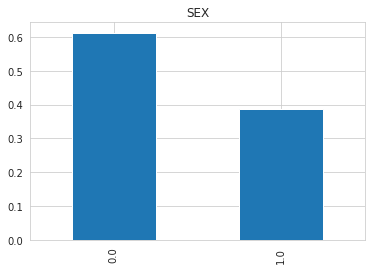

In [6]:

data['sex'].value_counts(normalize=True).plot.bar()
plt.title('SEX')

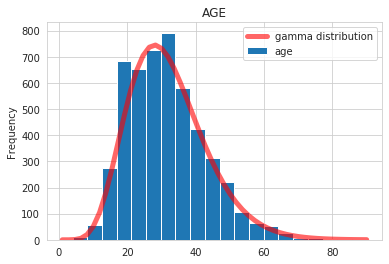

In [7]:
data['age'].plot.hist(bins=20)

x = np.linspace(1,90)
plt.plot(x, gamma.pdf(x, 8,0,4)*20000,'r-', lw=5, alpha=0.6, label='gamma distribution')

plt.title('AGE')
plt.legend()

Text(0.5, 1.0, 'Purchase')

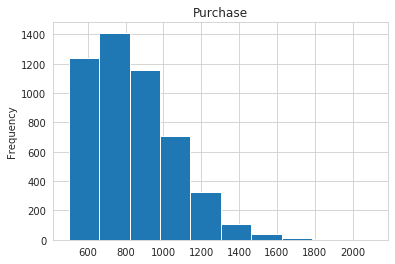

In [7]:
data['purchase'].plot.hist()
plt.title('Purchase')

## Balance of class

As result of generate 5K points using the funtion `SyntheticData` with `seed=123`, I obtain `3592 cases for class 1` and `1408 cases for class 0`, with an approximated `ratio of "2.3:1"`.
Although the balance of classes in the dataset is not perfect, the ratio between both is not different enough to <b>"1"</b> how to be shure about the need to apply specific strategies to solve the problem. As a first approach I will leave them.

Text(0.5, 1.0, 'Balance of Class')

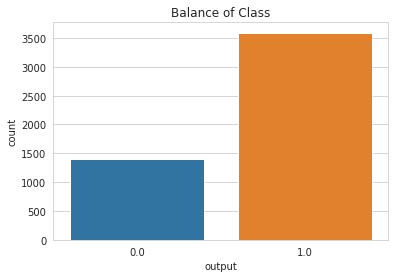

In [8]:
sns.countplot(data=data,x='output')
plt.title('Balance of Class')

In the dataset, the proportion of "Female" and "Male" (0 and 1 respectively) for each class is very different. "Female" are more balanced between both classes respect to "Male", which mostly belong to class 1.

Text(0.5, 1.0, 'Balance of Class by "sex"')

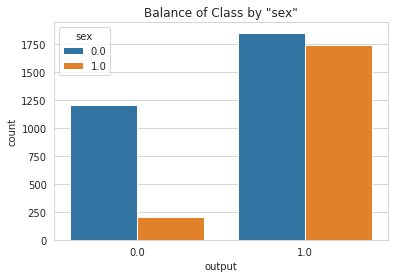

In [9]:
sns.countplot(data=data,x='output',hue='sex')
plt.title('Balance of Class by "sex"')

Text(0.5, 0.98, 'Distribution of Cases for "Male" (sex=1)')

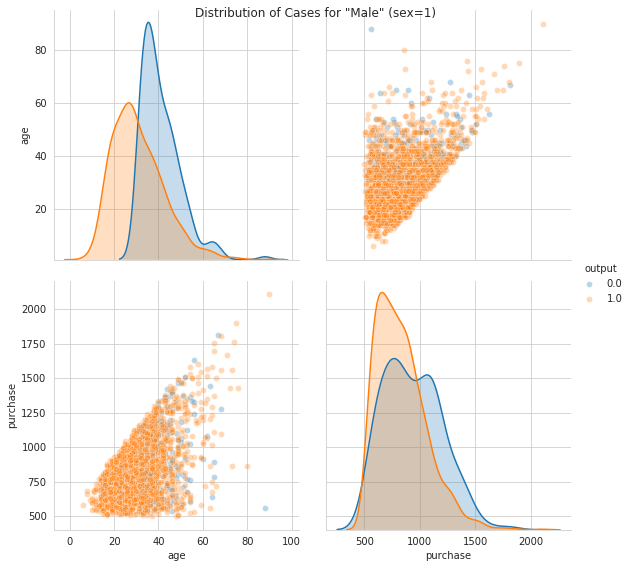

In [10]:
# Distribution of Cases for Male (sex=1)
g = sns.pairplot(data.loc[data['sex']==1], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,plot_kws={'alpha':0.3})
g.fig.suptitle('Distribution of Cases for "Male" (sex=1)')

Text(0.5, 0.98, 'Distribution of Cases for "Female" (sex=1)')

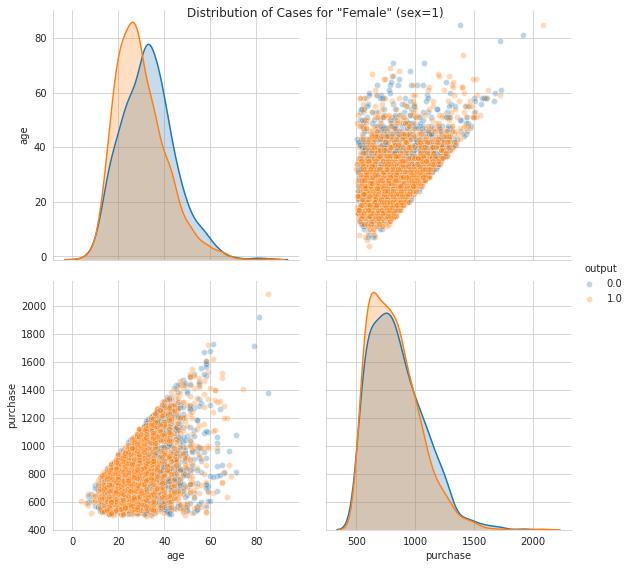

In [11]:
# Distribution of Cases for Female (sex=0)
g = sns.pairplot(data.loc[data['sex']==0], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,plot_kws={'alpha':0.3})
g.fig.suptitle('Distribution of Cases for "Female" (sex=1)')

## Correlation of Variables

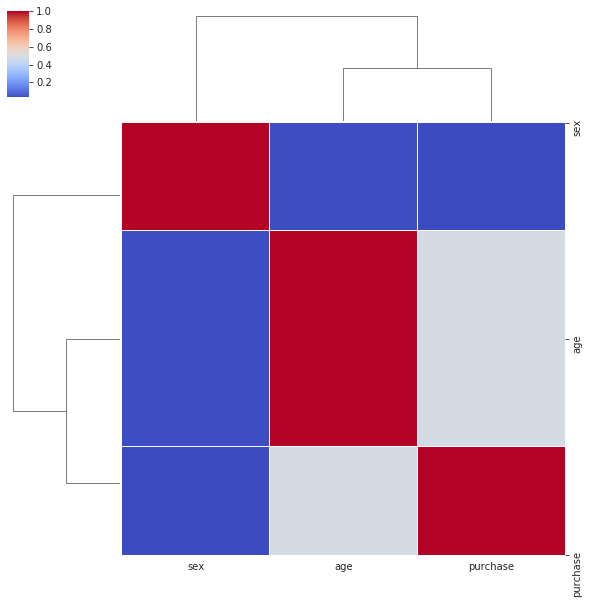

In [12]:
corr = data.drop(['output'], axis=1).corr()
sns.clustermap(corr, cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete')

# Construction of the models <a class="anchor" id="models"></a>

[Return to index...](#index)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [14]:
X, y = data.drop(['output'], axis=1), data[['output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Logistic Regression <a class="anchor" id="logreg"></a>

[Return to index...](#index)

### Preprocessing

In general, learning algorithms benefit from standardization of the data set. For instance,  the "l1" and "l2" regularizers of linear models assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. Because of this, the numeric variables in the dataset are preprocessed with the `StandardScaler` function prior to their use in the model.

In [16]:
numeric_columns = ['age','purchase']
categoric_columns = ['sex']

numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)],
                                 remainder='passthrough')

### Model

In [17]:
model = LogisticRegression(solver = 'liblinear',max_iter=1000)

### Pipeline

In order to define the flow of data from one stage to the other, I will use the `Pipeline` function.

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessing',preprocessor),
    ('classificator',model)
])

### Grid Search

Logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other. Unfortunately variables "age" and "purchase" are correlated. For deal with this problem is necesary penalize correlated variables through some regularization term added to the loss funtion. In the model, hyperparameter `penalty` permit select between a family of them ("l1", "l2" and "elastic-net"). In the problem I will work only with "l1" and "l2". Regularization has another hiperparameter asociated `C` which regulates how strength is the penalty for the correlated variables. 


<b>Resume of Hyperparameters to use   in this work:</b>

* ``penalty`` : 
    Specify the regularization that is applied.

* ``C`` : 
    Inverse of regularization strength.

* ``class_weight`` : 
    Adjust weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``.

In [19]:
lr_C =  [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]
reg = ['l1','l2']

## defino los hyperparámetros que voy a recorrer
param_grid = [
  {'classificator__C':lr_C, 'classificator__penalty':reg}
]

In [20]:
search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

### Best Model Found

In [21]:
search.best_estimator_['classificator']

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
results = pd.DataFrame(search.cv_results_)

In [23]:
l1_results = results.loc[results.param_classificator__penalty=='l1']
l2_results = results.loc[results.param_classificator__penalty=='l2']

In [24]:
def plot_train_test(results, parameter, color , label):
    
    param_C = results[f'param_classificator__{parameter}']
    
    perf_train = results['mean_train_score']
    std_train = results['std_train_score']
    ylow_train =   perf_train - std_train
    yup_train = perf_train + std_train
    
    perf_test = results['mean_test_score']
    std_test = results['std_test_score']
    ylow_test =   perf_test - std_test
    yup_test = perf_test + std_test
    
    try:
        ax
    except:
        fig, ax = plt.subplots(1)
    
    ax.plot(param_C,perf_train,color=color , label=f'{label}-train')
    ax.fill_between(param_C.astype(float), 
                    yup_train, 
                    ylow_train, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    
    ax.plot(param_C,perf_test, color=color, linestyle='--', label=f'{label}-validation')
    ax.fill_between(param_C.astype(float), 
                    yup_test, 
                    ylow_test, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    plt.xlabel(parameter)
    plt.ylabel('mean')
    plt.legend()

(0.7, 0.77)

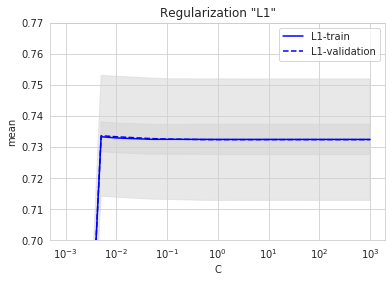

In [25]:
plot_train_test(l1_results, parameter='C', color='blue', label="L1")
plt.xscale('log')
plt.title('Regularization "L1"')
plt.ylim(0.70,0.77)

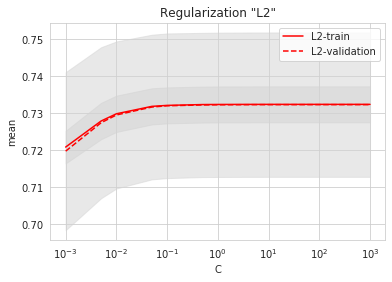

In [26]:
plot_train_test(l2_results, parameter='C', color='red', label="L2")
plt.title('Regularization "L2"')
plt.xscale('log')
#plt.ylim(0.88,0.91)

## Random Forest <a class="anchor" id="randomforest"></a>

[return to index...](#index)

### Preprocessing

Random Forest is a tree-based model and hence does not require feature scaling

### Model

In [31]:
model = RandomForestClassifier(random_state=SEED,max_features=None)

### Pipeline

If well in this situation I don't need really use pipeline to define the flow of data because there is just one stage, 

In [32]:
pipeline = Pipeline(steps=[
    ('classificator',model)
])

## Optimization of Hyperparameters

The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features)





## Hyperparameters

* ``n_estimators`` : 
    The number of trees in the forest.

* ``max_depth`` : 
    The maximum depth of the tree.

* ``min_samples_split`` : 
    The minimum number of samples required to split an internal node:

* ``min_samples_leaf`` : 
    The minimum number of samples required to be at a leaf node.

* ``max_features`` : 
    The number of features to consider when looking for the best split.

* ``min_impurity_decrease`` :
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.

* ``class_weight`` : Adjust weights inversely proportional to class frequencies 
    in the input data as :
    ``n_samples / (n_classes * np.bincount(y))``.


### Grid Search

In [ ]:
# The number of trees in the forest.
n_estimators = np.array([5, 10, 20 , 50, 100, 500])
min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True)
# The maximum depth of the tree.
max_depth = [5,10,50]#np.lspace(1, 5, 5, endpoint=True)
min_impurity_decrease = np.linspace(0,0.02, 20, endpoint=True)

param_grid = [
  {'classificator__n_estimators':n_estimators,
   'classificator__min_samples_split':min_samples_split,
   'classificator__max_depth':max_depth,
   'classificator__min_impurity_decrease':min_impurity_decrease}
 ]

In [34]:
search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

KeyboardInterrupt: 

### Best Model

In [166]:
best_params = search.best_estimator_['classificator'].get_params()
best_params

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.005263157894736842, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

In [161]:
results = pd.DataFrame(search.cv_results_)

In [167]:
n_estim_result = results.loc[(results['param_classificator__max_depth']==best_params['max_depth']) & \
                             (results['param_classificator__min_samples_split']==best_params['min_samples_split']) & \
                             (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

In [51]:
plot_train_test(n_estim_result, parameter='n_estimators',color='red',label='best')
plt.xscale('log')
plt.title('N-Estimators (best = 10)')

NameError: name 'plot_train_test' is not defined

In [169]:
min_sample_split_results = results.loc[(results['param_classificator__max_depth']==best_params['max_depth']) & \
                                       (results['param_classificator__n_estimators']==best_params['n_estimators']) & \
                                       (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

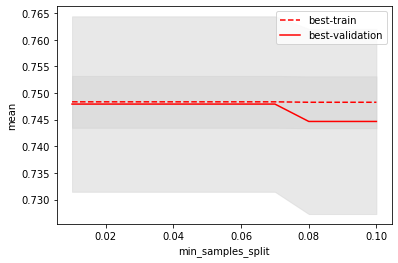

In [170]:
plot_train_test(min_sample_split_results, parameter='min_samples_split',color='red',label='best')

In [171]:
max_depth_results = results.loc[(results['param_classificator__n_estimators']==best_params['n_estimators']) & \
                             (results['param_classificator__min_samples_split']==best_params['min_samples_split']) & \
                             (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

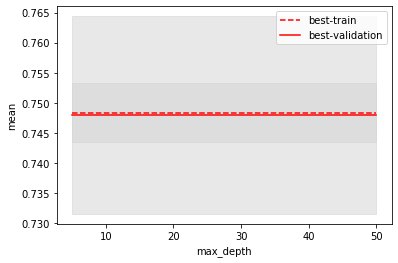

In [172]:
plot_train_test(max_depth_results, parameter='max_depth',color='red',label='best')

In [132]:
min_impurity_decrease_results = results.loc[(results['param_classificator__max_depth']==3) & \
                             (results['param_classificator__min_samples_split']==0.01) & \
                             (results['param_classificator__n_estimators']==10)]

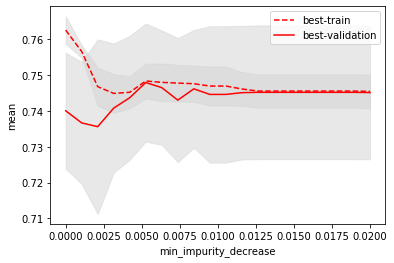

In [133]:
plot_train_test(min_impurity_decrease_results, parameter='min_impurity_decrease',color='red',label='best')

In [144]:
from sklearn.model_selection import cross_val_score

In [145]:
pipeline = Pipeline(steps = [('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 50))])

In [149]:
rfcv = cross_val_score(pipeline, X_train, y_train['output'].ravel(), cv=5,scoring = 'roc_auc')
print(np.mean(rfcv),np.std(rfcv))


0.6761778736516111 0.018025782300633765


In [ ]:
'param_classificator__n_estimators',
'param_classificator__min_samples_split',
'param_classificator__max_depth',
'param_classificator__min_impurity_decrease'

In [134]:
from sklearn.model_selection import RandomizedSearchCV

In [135]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

In [137]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [141]:
for param, values in random_grid.items():
    print(f'{param}: {values}')

n_estimators: [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
max_features: ['auto', 'sqrt']
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV